<a href="https://colab.research.google.com/github/AronTech1/PRODIGY_ML_01/blob/main/TASK1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost
!pip install optuna  # Install the optuna library

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

import pandas as pd
import numpy as np
#import Regression Modules - ML
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.multioutput import MultiOutputRegressor

# import tuing model
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import optuna
from sklearn.preprocessing import StandardScaler

# split data
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
train_df = pd.read_csv("/content/drive/MyDrive/MACHINE LEARNING INTERNSHIP/Task1/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/MACHINE LEARNING INTERNSHIP/Task1/test.csv")

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

<Axes: >

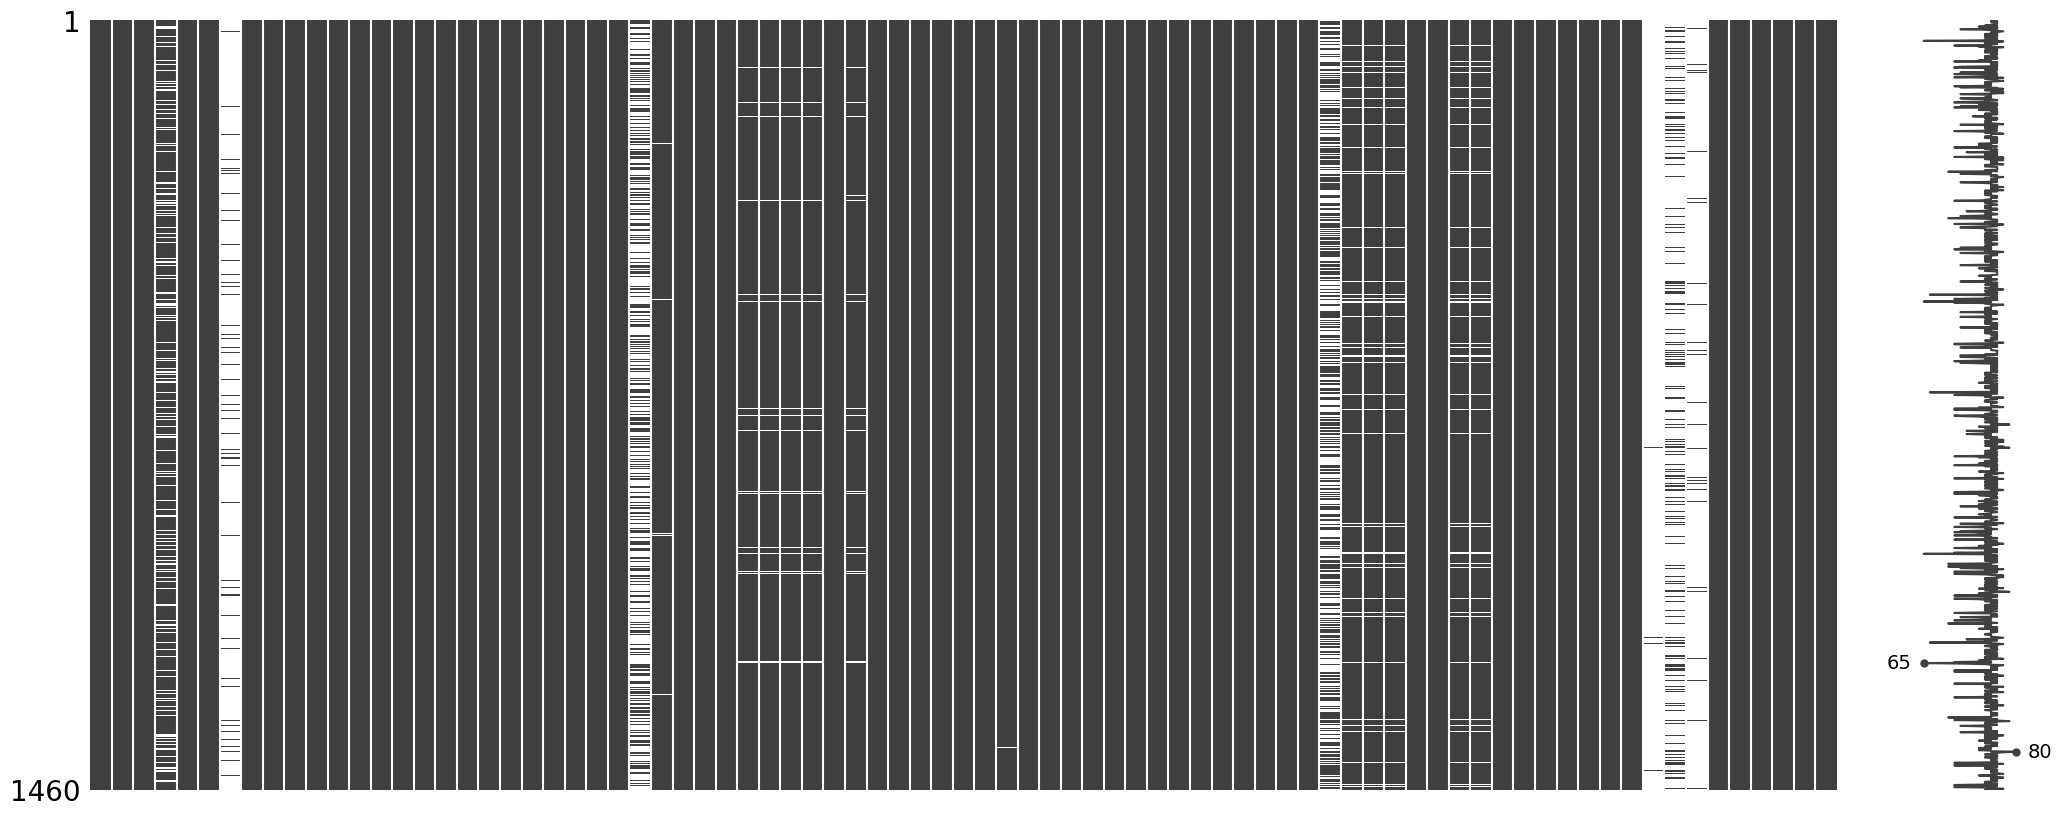

In [10]:
msno.matrix(train_df)

<Axes: >

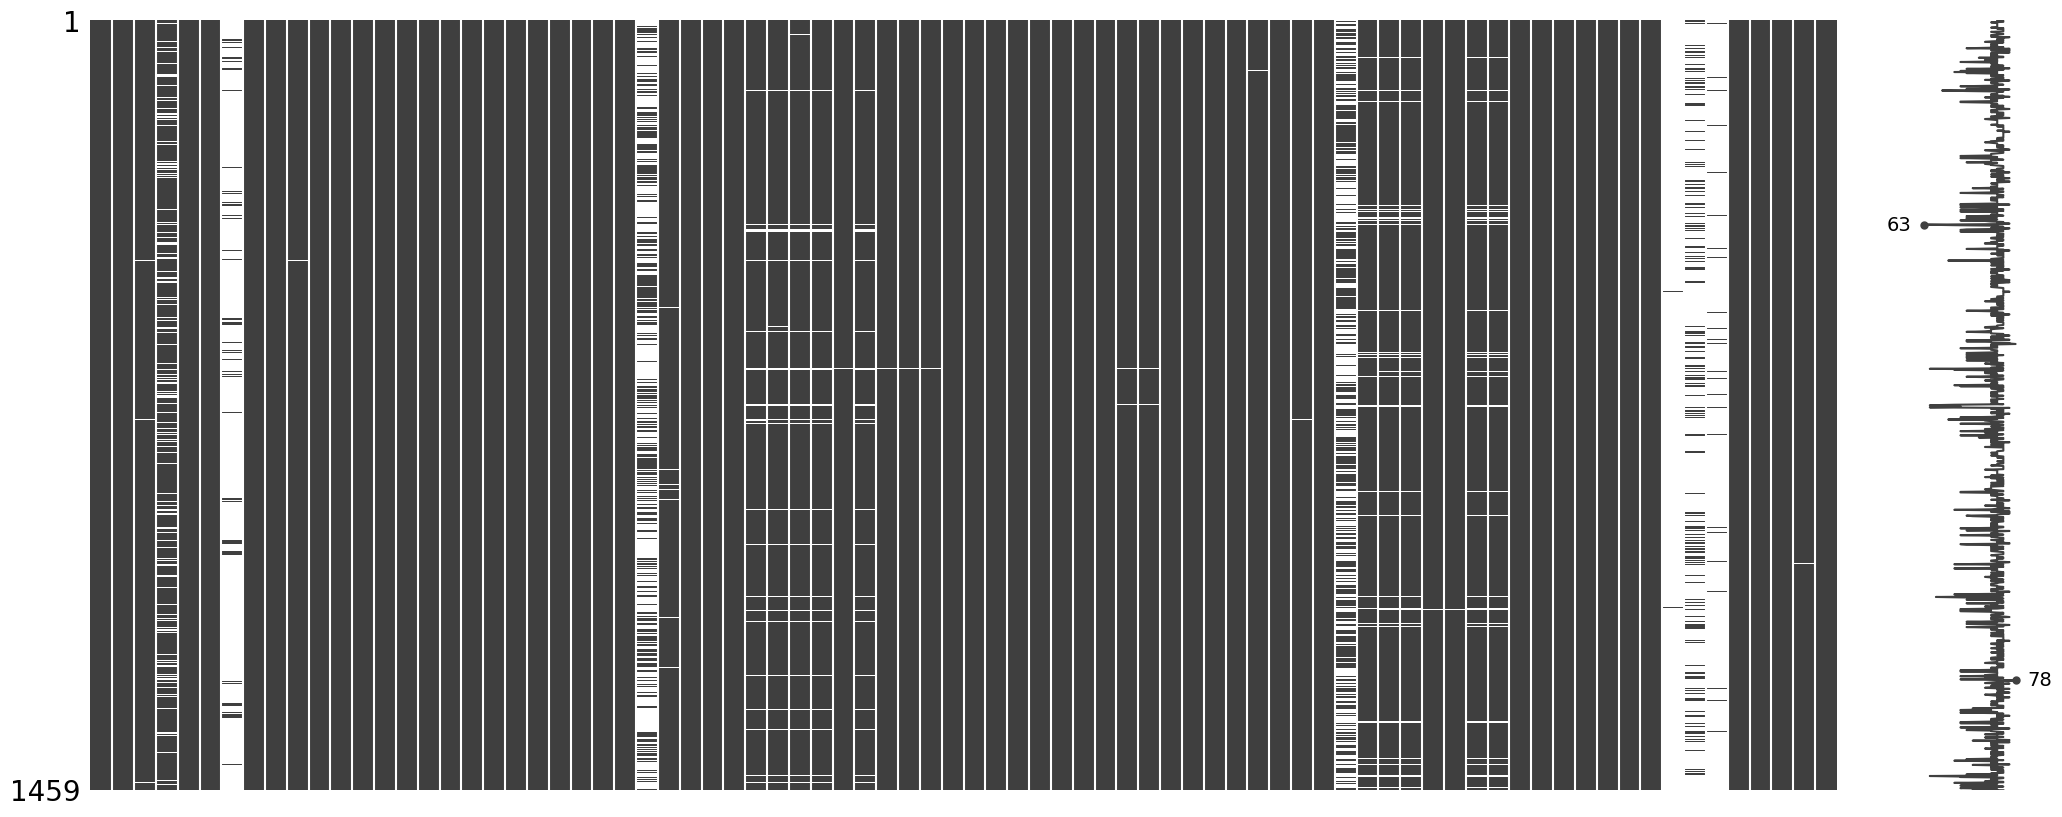

In [11]:
msno.matrix(test_df)

In [12]:
remove_list1=["Id"]
for i in train_df.columns.tolist():
    if train_df[i].isnull().sum() >= 500:
        print(i,train_df[i].isnull().sum())
        remove_list1.append(i)

Alley 1369
MasVnrType 872
FireplaceQu 690
PoolQC 1453
Fence 1179
MiscFeature 1406


In [13]:
train_df = train_df.drop(columns=remove_list1)
test_df = test_df.drop(columns=remove_list1)

In [14]:
object_columns = train_df.select_dtypes(include=['object']).columns.tolist()
print(object_columns)

['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']


In [15]:
for i in object_columns:
    frequency = train_df[i].value_counts(normalize=True)  # Normalize to get frequency ratio
    train_df[str(i)+'_encoded'] = train_df[i].map(frequency)
for i in object_columns:
    train_df = train_df.drop(columns = [i])

In [16]:
object_columns = test_df.select_dtypes(include=['object']).columns.tolist()
for i in object_columns:
    frequency = test_df[i].value_counts(normalize=True)  # Normalize to get frequency ratio
    test_df[str(i)+'_encoded'] = test_df[i].map(frequency)
for i in object_columns:
    test_df = test_df.drop(columns = [i])

In [17]:
per_df = pd.DataFrame()
for i in range(len(train_df)):
    if train_df.iloc[i].isnull().sum() == 0:
        per_df = per_df._append(train_df.iloc[i], ignore_index=True)

In [18]:
per_df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,Electrical_encoded,KitchenQual_encoded,Functional_encoded,GarageType_encoded,GarageFinish_encoded,GarageQual_encoded,GarageCond_encoded,PavedDrive_encoded,SaleType_encoded,SaleCondition_encoded
0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,0.0,...,0.914325,0.401370,0.931507,0.630892,0.306019,0.950689,0.961566,0.917808,0.867808,0.820548
1,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,0.0,...,0.914325,0.503425,0.931507,0.630892,0.306019,0.950689,0.961566,0.917808,0.867808,0.820548
2,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,0.0,...,0.914325,0.401370,0.931507,0.630892,0.306019,0.950689,0.961566,0.917808,0.867808,0.820548
3,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,0.0,...,0.914325,0.401370,0.931507,0.280638,0.438724,0.950689,0.961566,0.917808,0.867808,0.069178
4,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,0.0,...,0.914325,0.401370,0.931507,0.630892,0.306019,0.950689,0.961566,0.917808,0.867808,0.820548


In [19]:
per_test_df = per_df.drop(columns=['SalePrice'])
per_test_df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,Electrical_encoded,KitchenQual_encoded,Functional_encoded,GarageType_encoded,GarageFinish_encoded,GarageQual_encoded,GarageCond_encoded,PavedDrive_encoded,SaleType_encoded,SaleCondition_encoded
0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,0.0,...,0.914325,0.401370,0.931507,0.630892,0.306019,0.950689,0.961566,0.917808,0.867808,0.820548
1,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,0.0,...,0.914325,0.503425,0.931507,0.630892,0.306019,0.950689,0.961566,0.917808,0.867808,0.820548
2,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,0.0,...,0.914325,0.401370,0.931507,0.630892,0.306019,0.950689,0.961566,0.917808,0.867808,0.820548
3,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,0.0,...,0.914325,0.401370,0.931507,0.280638,0.438724,0.950689,0.961566,0.917808,0.867808,0.069178
4,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,0.0,...,0.914325,0.401370,0.931507,0.630892,0.306019,0.950689,0.961566,0.917808,0.867808,0.820548
